<a href="https://colab.research.google.com/github/ucaokylong/speech_recognition_simple_word/blob/main/Speech_Recognition_8Classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U -q tensorflow tensorflow_datasets

In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 20 not upgraded.
Need to get 430 MB of archives.
After this operation, 1,153 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 12s (36.9 MB/s)
(Reading database ... 128275 files and directories currently installed.)
Removing libcudnn8-dev (8.7.0.84-1+cuda11.8) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
dpkg: warning: downgrading libcudnn8 from 8.7.0.84-1+cuda11.8 to 8.1.0.77-1+cuda11.2
(Reading database ... 128242 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.1.0.

In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers import *
from tensorflow.keras import models
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from IPython import display

# **Import the mini Speech Commands dataset**

In [ ]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182082353/182082353 [==============================] - 1s 0us/step


The dataset's audio clips are stored in eight folders

In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['stop' 'right' 'down' 'yes' 'no' 'left' 'up' 'go']


Divided into directories this way, you can easily load the data

In [ ]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of (batch, samples, channels).

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the tf.squeeze function to drop the extra axis

In [ ]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The utils.audio_dataset_from_directory function only returns up to two splits. It's a good idea to keep a test set separate from your validation set. Ideally you'd keep it in a separate directory, but in this case you can use Dataset.shard to split the validation set into two halves. Note that iterating over any shard will load all the data, and only keep its fraction.

In [ ]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

## Plot a few audio waveforms

In [ ]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


In [ ]:
label_names[[1,1,3,0]]

array(['go', 'go', 'no', 'down'], dtype='<U5')

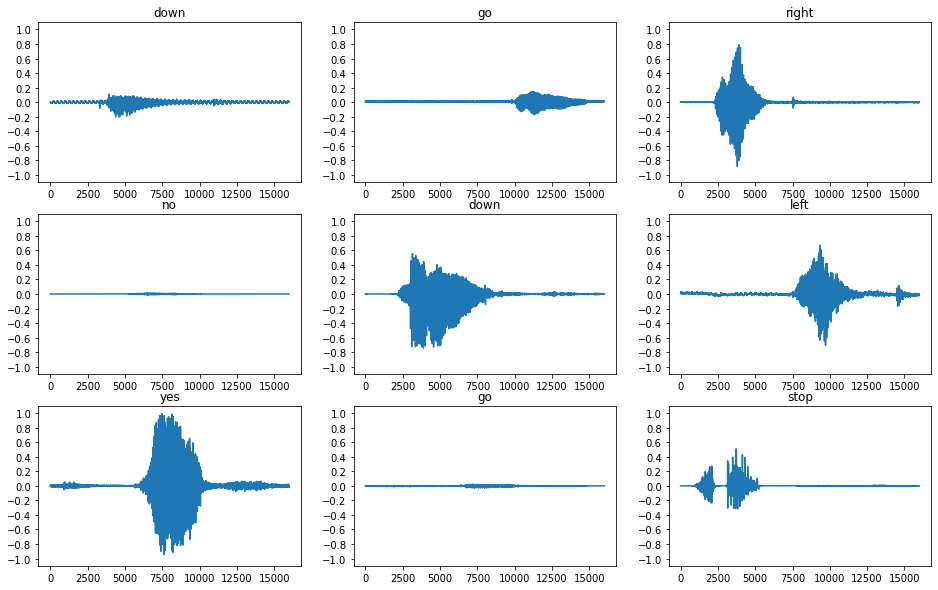

In [ ]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

# Convert waveforms to spectrograms
Transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the short-time Fourier transform (STFT) to convert the waveforms to as spectrograms, which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

In [ ]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=256, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio

In [ ]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: down
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: go
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: right
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Function for displaying a spectrogram

In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time)

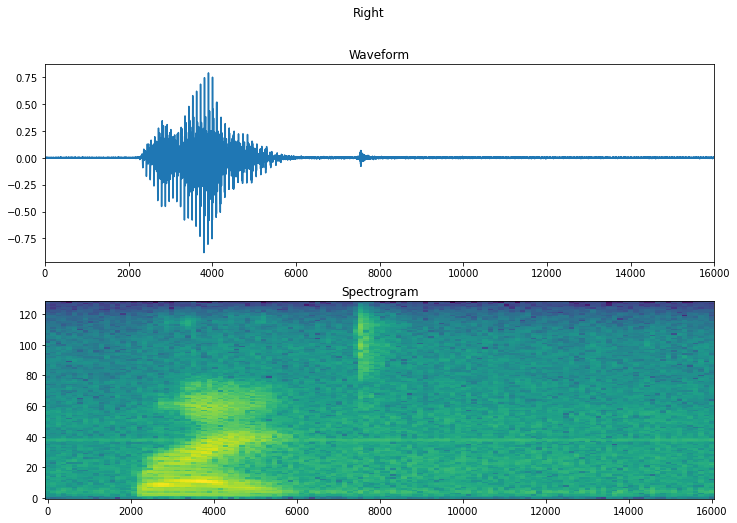

In [ ]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Create spectrogramn datasets from the audio datasets

In [ ]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Examine the spectrograms for different examples of the dataset

In [ ]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

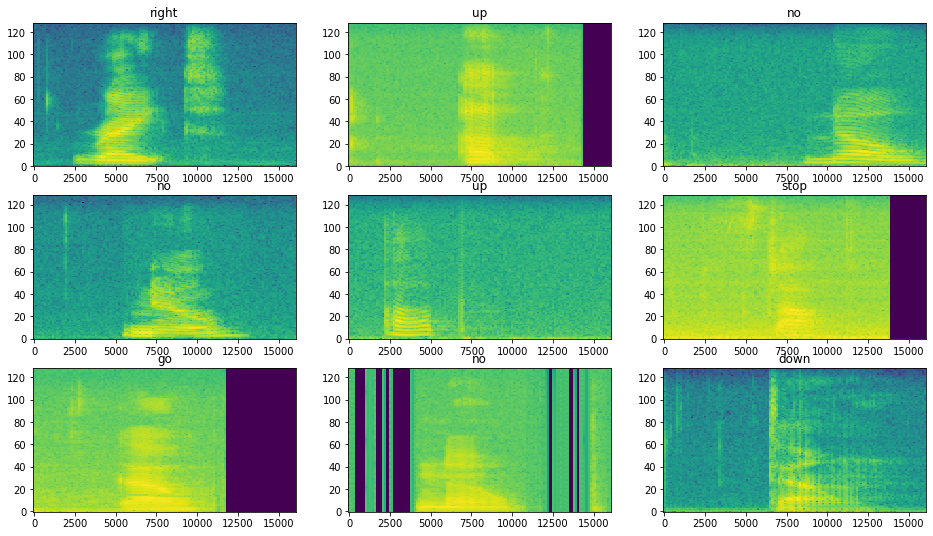

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

# Build and train the model

In [ ]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu',padding="same"),
    layers.Conv2D(64, 3, activation='relu',padding="same"),
    layers.Dropout(0.25),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu',padding="same"),
    layers.Conv2D(16, 3, activation='relu',padding="same"),
    layers.Dropout(0.25),
    tf.keras.layers.GlobalMaxPooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_labels, activation="softmax")
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_6 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_6 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 32, 32, 32)        320       
                                                                 
 conv2d_21 (Conv2D)          (None, 32, 32, 64)        18496     
                                                                 
 dropout_29 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                       

In [ ]:
lrd = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 5,verbose = 1,factor = 0.5, min_lr = 0.00001)
check_point = ModelCheckpoint('modelcp2.h5',
                              save_best_only= True, mode = 'auto')
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

EPOCHS = 30
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks= [lrd, check_point]
)
model.save("voicerec2.h5")

Epoch 1/30
100/100 [==============================] - 49s 457ms/step - loss: 2.0089 - accuracy: 0.2070 - val_loss: 1.7927 - val_accuracy: 0.4245 - lr: 0.0010
Epoch 2/30
100/100 [==============================] - 46s 463ms/step - loss: 1.5419 - accuracy: 0.4322 - val_loss: 1.3337 - val_accuracy: 0.5573 - lr: 0.0010
Epoch 3/30
100/100 [==============================] - 44s 438ms/step - loss: 1.1114 - accuracy: 0.5864 - val_loss: 0.9664 - val_accuracy: 0.7240 - lr: 0.0010
Epoch 4/30
100/100 [==============================] - 45s 442ms/step - loss: 0.9002 - accuracy: 0.6758 - val_loss: 0.7718 - val_accuracy: 0.7708 - lr: 0.0010
Epoch 5/30
100/100 [==============================] - 44s 438ms/step - loss: 0.7626 - accuracy: 0.7284 - val_loss: 0.7208 - val_accuracy: 0.7773 - lr: 0.0010
Epoch 6/30
100/100 [==============================] - 46s 465ms/step - loss: 0.6609 - accuracy: 0.7684 - val_loss: 0.6275 - val_accuracy: 0.8034 - lr: 0.0010
Epoch 7/30
100/100 [==============================] 

## Plot the training and validation loss curves

Text(0, 0.5, 'Accuracy [%]')

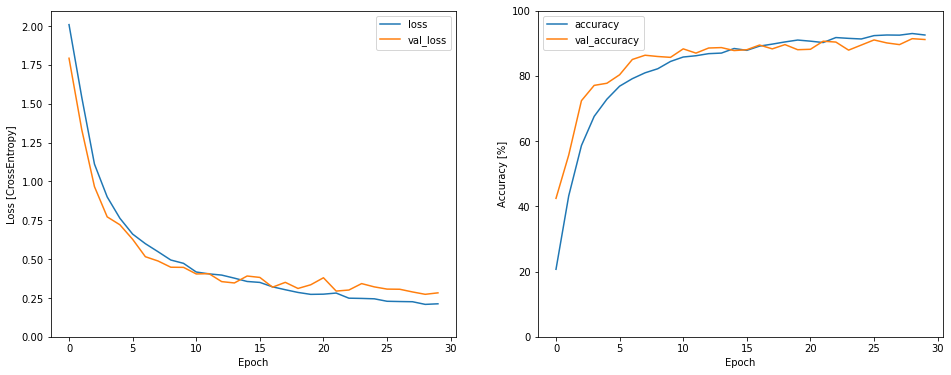

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')